In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 13)
from math import exp
import math
from scipy.special import lambertw
from pprint import pprint
from numpy import logspace
def lambert(x):
    return lambertw(x, -1)
from PySpice.Spice.Netlist import Circuit
boltz = 1.38064852e-23
zeroC = 273.15
qe = 1.60217662e-19

In [2]:
from importlib import reload
reload(plt)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [3]:
# Working from (Cubas, 2014)
ztj_specs = {'vmp': 2.41,
             'voc': 2.726,
             'imp': 16.5e-3 * 30,
             'isc': 17.4e-3 * 30,
             'a'  : 3.6, # guessing, it's 3*1.2 because it's a triple-junction cell
             'temp': 298.15,
             'tempco': {'voc': -6.3e-3,
                        'isc': 11.7e-6 * 30,
                        'imp': 9.1e-6 * 30,
                        'vmp': -6.7e-3
                       }
            }
blue_specs = {'a'  : 1.51,
              'imp': 0.0934,
              'vmp': 0.433,
              'isc': 0.1023,
              'voc': 0.536,
              'temp': 300
             }

def cell_tempco(specs, temp):
    retval = {k: specs[k] + specs['tempco'][k] * (temp - specs['temp'])
              for k in ('vmp', 'voc', 'imp', 'isc')}
    retval['a'] = specs['a']
    retval['temp'] = temp
    return retval

def calc_cubas(vmp, voc, imp, isc, a, temp = 298.15):
    vt = boltz * temp / qe
    
    A = a * vt / imp
    B = -1 * vmp * (2 * imp - isc) / (vmp * isc + voc * (imp - isc))
    C = (vmp * isc - voc * imp) / (vmp * isc + voc * (imp - isc)) - (2 * vmp - voc) / (a * vt)
    D = (vmp - voc) / (a * vt)
    Rs = A * (lambert(B * exp(C)) - (D + C))
    
    Rsh = (vmp - imp * Rs) * (vmp - Rs * (isc - imp) - a * vt) / ((vmp - imp * Rs) * (isc - imp) - a * vt * imp)
    Io = ((Rsh + Rs) * isc - voc) / (Rsh * exp(voc / (a * vt)))
    Ipv = (Rsh + Rs) * isc / Rsh
    
    ret = {'rs': Rs, 'rsh': Rsh, 'io': Io, 'ipv': Ipv, 'a': a, 'temp': temp}
    for k,v in ret.items():
        if abs(v.imag) > 0.001 or abs(v.imag) > 0.001 * abs(v.real):
            print("wait what? Imaginary component to {}: {}".format(k, v))
        ret[k] = v.real
    return ret

In [4]:
ztj = calc_cubas(**{k:ztj_specs[k] for k in 'vmp voc imp isc a temp'.split()})
blue = calc_cubas(**blue_specs)
pprint(blue)
pprint(ztj)

{'a': 1.51,
 'io': 1.1082397288357229e-07,
 'ipv': 0.10230609660076519,
 'rs': 0.065206989238963,
 'rsh': 1094.1630026402197,
 'temp': 300}
{'a': 3.6,
 'io': 8.131417763694951e-14,
 'ipv': 0.5220361930750081,
 'rs': 0.020276131769475635,
 'rsh': 292.43552202465725,
 'temp': 298.15}


In [9]:
def to_file(f, specs):
    f.write('.SUBCKT pvcell neg pos PARAMS: Illumination=1\n')
    f.write('.model foo D (IS={} N={} TNOM={})\n'.format(specs['io'], specs['a'], specs['temp'] - zeroC))
    f.write('Isrc neg internal DC {{Illumination * {}}}\n'.format(specs['ipv']))
    f.write('Dfoo internal neg foo\n')
    f.write('Rsh internal neg {}\n'.format(specs['rsh']))
    f.write('Rs internal pos {}\n'.format(specs['rs']))
    f.write('.ENDS pvcell\n')

In [10]:
with open('spicethings/pvcell.sub', 'w') as f:
    to_file(f, ztj)

Isc: 0.522 A
Voc: 2.74 V
MPP: 1.20 W  (0.489 A @ 2.45 V)
(300 points tested in 0.301 seconds)
{'vmp': 2.41, 'voc': 2.726, 'imp': 0.495, 'isc': 0.522, 'a': 3.6, 'temp': 298.15, 'tempco': {'voc': -0.0063, 'isc': 0.00035099999999999997, 'imp': 0.00027299999999999997, 'vmp': -0.0067}}


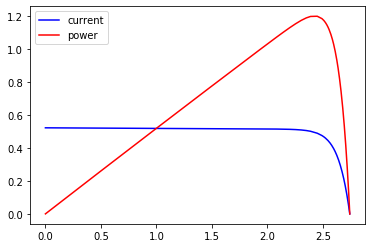

In [5]:
import time

def sweep_cell(cell_params, temp=300):
    ckt = Circuit('Performance Sweep')
    d = ckt.model('foo', 'D', IS=cell_params['io'], N=cell_params['a'], TNOM=(temp - zeroC))
    ckt.I('src', ckt.gnd, 1, cell_params['ipv'])
    ckt.D('diode', 1, ckt.gnd, model='foo')
    ckt.R('sh', 1, ckt.gnd, cell_params['rsh'])
    ckt.R('s', 1, 'out', cell_params['rs'])
    ckt.R('load', 'out', ckt.gnd, 1)
    ckt['Rload'].plus.add_current_probe(ckt)
    
    results = sweep_res(ckt, rmin=1e-3, rmax=1e6, resistor='Rload', temp=temp,
                        voltages=['out'], currents=['vrload_plus'])
    res = {}
    res['vout'] = results['voltages']['out']
    res['aout'] = results['currents']['vrload_plus']
    res['rload'] = results['r']
    res['pout'] = [v * a for v,a in zip(res['vout'], res['aout'])]
    res['Isc'] = res['aout'][0]
    res['Voc'] = res['vout'][-1]
    res['mpp'] = res['pout'].index(max(res['pout']))
    return res

def sweep_res(circuit, rmin, rmax, resistor, temp=298, voltages=[], currents=[]):
    rlo, rhi = rmin, rmax
    min_chg = 0.01
    stack = [(rlo, rhi)]
    def calc(r):
        circuit[resistor].resistance = r
        res = circuit.simulator(temperature=(temp - zeroC)).operating_point()
        return {'voltages': {v: float(res.nodes[v]) for v in voltages},
                'currents': {a: float(res.branches[a]) for a in currents}
               }
    
    def precise_enough(a, b, minabs=0.002, percent=0.03):
        for name, xs in (('voltages', voltages), ('currents', currents)):
            for x in xs:
                ax, bx = a[name][x], b[name][x]
                delta = abs(ax - bx)
                if delta < minabs:
                    return True
                if ax != 0:
                    if abs(delta / ax) > percent:
                        return False
                elif bx != 0:
                    if abs(delta / bx) > percent:
                        return False
        return True
    
    results = {rlo : calc(rlo), rhi : calc(rhi)}
    vv, aa = voltages[0], currents[0]
    while len(stack):
        rlo, rhi = stack.pop()
        if precise_enough(results[rlo], results[rhi]):
            continue
        rmid = (rlo + rhi) / 2
        results[rmid] = calc(rmid)
        stack.extend([(rlo, rmid), (rmid, rhi)])
    r_sorted = sorted(results.keys())
    retval = {'r': r_sorted,
              'voltages' : {k: [results[r]['voltages'][k] for r in r_sorted] for k in voltages},
              'currents' : {k: [results[r]['currents'][k] for r in r_sorted] for k in currents},
             }
    return retval


tstart = time.time()
res = sweep_cell(ztj)
tstop = time.time()

print('Isc: {:.3f} A'.format(res['Isc']))
print('Voc: {:.2f} V'.format(res['Voc']))
ind = res['mpp']
print('MPP: {:.2f} W  ({:.3f} A @ {:.2f} V)'.format(res['pout'][ind], res['aout'][ind], res['vout'][ind]))
print('({} points tested in {:.3f} seconds)'.format(len(res['pout']), tstop - tstart))

print(ztj_specs)

plt.plot(res['vout'], res['aout'], label='current', color='b')
plt.plot(res['vout'], res['pout'], label='power', color='r')
plt.legend()
plt.show()

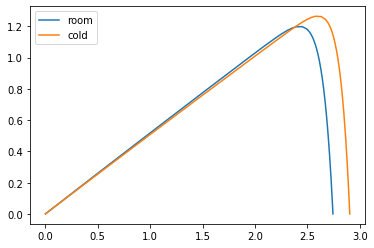

In [6]:
room = sweep_cell(ztj)
coldcell = calc_cubas(**cell_tempco(ztj_specs, 270))
cold = sweep_cell(coldcell, 270)
plt.plot(room['vout'], room['pout'], label='room')
plt.plot(cold['vout'], cold['pout'], label='cold')
plt.legend()
plt.show()

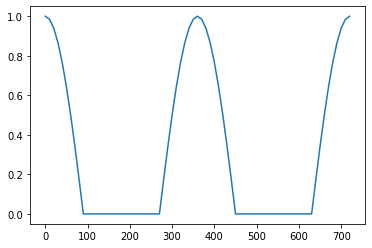

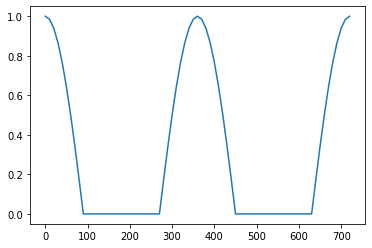

In [7]:
# For the angle of incidence
from math import cos, radians

def angle_coeff(theta, phi):
    # by convention, phi is the angle between y+ (spin axis when shawarma-mode) and the plane normal to the sun vector
    #  theta is the angle between the normal of this cell, and the max alignment with the sun
    if phi < 0:
        phi = 0 - phi
    phi %= 360
    if 90 <= phi <= 270:
        theta += 180
    theta %= 360
    if 90 <= theta <= 270:
        return 0
    return cos(radians(theta)) * cos(radians(phi))

angles = [i * 10 for i in range(73)]
plt.plot(angles, [angle_coeff(i, 0) for i in angles])
plt.show()
plt.plot(angles, [angle_coeff(0, i) for i in angles])



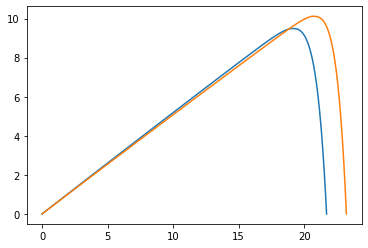

In [8]:
# So we've got a column of, say, 8 cells. A nominal temperature for the column, and a gradient along it.
def add_cell(circuit, specs, name, temp, node1='', node2=''):
    def fmt(s):
        return s + '_' + str(name)
    model = circuit.model(fmt('Dint'), 'D', IS=specs['io'], N=specs['a'],
                          TNOM=(specs['temp'] - zeroC), DTEMP=(temp - specs['temp']))
    bot, mid, top = (node1 or fmt('cell_bot')), fmt('cell_mid'), (node2 or fmt('cell_top'))
    circuit.I(fmt('src'), bot, mid, specs['ipv'])
    circuit.D(fmt('diode'), mid, bot, model=fmt('dint'))
    circuit.R(fmt('sh'), mid, bot, specs['rsh'])
    circuit.R(fmt('s'), mid, top, specs['rs'])
    return (bot, top)

def column_series(tnom, tgrad, theta, phi, cell):
    ckt = Circuit('')
    for i in range(8):
        ypos = i - 3.5
        tcell = tnom + tgrad(ypos)
        specs = calc_cubas(**cell_tempco(cell, tcell))
        specs['ipv'] *= angle_coeff(theta, phi)
        add_cell(ckt, specs, i, tcell, node2='cell_bot_{}'.format(i+1))
    ckt.R('conn', ckt.gnd, 'cell_bot_0', 0.001)
    ckt.R('load', 'cell_bot_8', ckt.gnd, 1)   
    ckt['Rload'].plus.add_current_probe(ckt)
    results = sweep_res(ckt, rmin=1e-3, rmax=1e6, resistor='Rload', temp=tnom,
                        voltages=['cell_bot_8'], currents=['vrload_plus'])
    retval = {'vout': results['voltages']['cell_bot_8'],
              'aout': results['currents']['vrload_plus']
             }
    retval['pout'] = [v*a for v,a in zip(retval['vout'], retval['aout'])]
    retval['mpp'] = retval['pout'].index(max(retval['pout']))
    return retval

def tt(y):
    return y

r = column_series(300, tt, 0, 0, ztj_specs)
plt.plot(r['vout'], r['pout'])
r = column_series(270, tt, 0, 0, ztj_specs)
plt.plot(r['vout'], r['pout'])
plt.show()

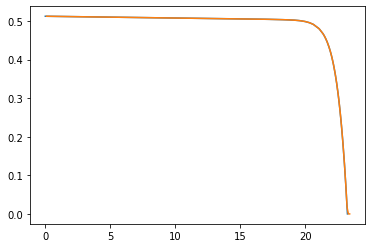

In [10]:
# We will also want to be able to look up current vs. voltage
def current_at(v, cell_iv):
    voltages = cell_iv['vout']
    currents = cell_iv['aout']
    i, j = 0, len(voltages) - 1
    # We're not doing dumb extrapolation
    if v < voltages[0]:
        return currents[0]
    if v > voltages[-1]:
        return 0
    while j - 1 > i:
        mid = (i + j) // 2
        if voltages[mid] > v:
            j = mid
        else:
            i = mid
    # v is in the range (i,j)
    frac = (v - voltages[i]) / (voltages[j] - voltages[i])
    return currents[i] + frac * (currents[j] - currents[i])

plt.plot(r['vout'], r['aout'])
resamp = [0.1 * v for v in range(1,235)]
plt.plot(resamp, [current_at(v, r) for v in resamp])

In [11]:
# let's have a pretend satellite, it's a cylinder with a column of 8 cells every 30 degrees radially
# - the sun is at theta=0, phi=0
# - temperature is 300K - 40 * cos(theta - 180)
# - temperature drops by 10 degrees (linear slope) from the center of the panel to the top/bottom edges

def tgrad(y):
    return (10/3.5) * y
    
panels = {theta: column_series((300 - 40*cos(theta - 180)), tgrad, theta, 0, ztj_specs)
          for theta in range(0, 360, 30) if angle_coeff(theta, 0) > 0.001}

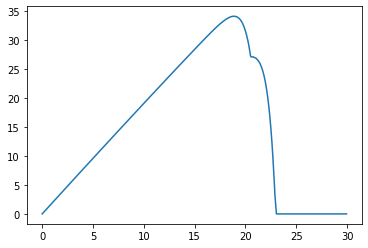

34.13612397788937 36.119791756107425


In [12]:
vsweep = [0.05 * i for i in range(int(30 / 0.05))]
all_a = [sum([current_at(v, panel) for panel in panels.values()]) for v in vsweep]
plt.plot(vsweep, [v*a for v,a in zip(vsweep, all_a)])
plt.show()
print(max([v*a for v,a in zip(vsweep, all_a)]), sum([p['vout'][p['mpp']] * p['aout'][p['mpp']]
                                                     for p in panels.values()]))